In [12]:
from glob import glob
import os
from collections import defaultdict
import cv2
from  matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import json
from tqdm import tqdm
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.optim as optim

from models import Densenet
from ImgDataset import ImgDataset, CombineImgDataset
from tqdm import tqdm

%matplotlib inline

path = '/nfs/nas-5.1/wbcheng/Chinese_Word_Recognition/'

seed = 5487
batch_size = 128
device = 'cuda:0'
load_model_path = '/nfs/nas-5.1/wbcheng/CWR_models/Desnet_All/{2}_loss.pth'
torch.manual_seed(seed)
np.random.seed(seed)
data_path = './combine_dataset.txt'

with open('./word2label.json', 'r', encoding='utf-8') as f:
    word2label = json.load(f)
label2word = {val:key for key, val in word2label.items()}

model = Densenet(len(word2label))
model.load_state_dict(torch.load(load_model_path))
model = model.to(device)

model.eval()
softmax = nn.Softmax(dim=1)

In [41]:
def preprocess_img(img):
    _, thre_img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    thre_img = cv2.fastNlMeansDenoising(thre_img, h=13, searchWindowSize=7)
    
    thre_img = cv2.fastNlMeansDenoising(thre_img, h=13, searchWindowSize=7)
    kernel = np.ones((3,3), np.uint8)
    thre_img = cv2.erode(thre_img, kernel, iterations = 1)

    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
    dilate = cv2.dilate(thre_img, rect_kernel, iterations = 1)
    
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0: bound = cv2.resize(img, (50,50))
    else:
        max_area = -1
        bx, by, bw, bh = None, None, None, None
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w * h > max_area:
                bx, by, bw, bh = x, y, w, h
                max_area = w * h

        bound = cv2.resize(img[by:by+bh, bx:bx+bw], (50, 50))
        
    _, bound = cv2.threshold(bound, 0, 255, cv2.THRESH_OTSU)
    bound = cv2.cvtColor(bound, cv2.COLOR_GRAY2BGR)

    tmp_bound = bound
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    bound = transform(bound)
    
    return tmp_bound, bound

def predict_img(img):
    tmp_bound, img = preprocess_img(img)
    img = img.to(device)
    img = torch.unsqueeze(img, dim=0)
    print(img.shape)
    with torch.no_grad():
        out = model(img)
        out = softmax(out)
        val, pred = torch.max(out, 1)
        print(pred, val)
        pred = label2word[int(pred.item())]
    print('Finish prediction')
    return pred, tmp_bound

bound gray shape  (50, 50)
bound gray thres  (50, 50)
bound adter convert  (50, 50, 3)
torch.Size([3, 50, 50])
torch.Size([1, 3, 50, 50])
tensor([709], device='cuda:0') tensor([0.7602], device='cuda:0')
Finish prediction
敬


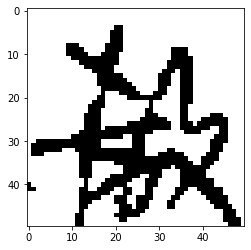


bound gray shape  (50, 50)
bound gray thres  (50, 50)
bound adter convert  (50, 50, 3)
torch.Size([3, 50, 50])
torch.Size([1, 3, 50, 50])
tensor([1], device='cuda:0') tensor([0.9996], device='cuda:0')
Finish prediction
卓


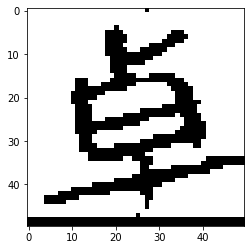


bound gray shape  (50, 50)
bound gray thres  (50, 50)
bound adter convert  (50, 50, 3)
torch.Size([3, 50, 50])
torch.Size([1, 3, 50, 50])
tensor([2], device='cuda:0') tensor([0.7489], device='cuda:0')
Finish prediction
逸


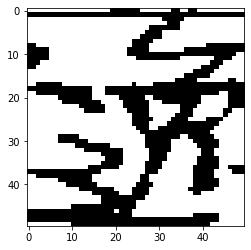


bound gray shape  (50, 50)
bound gray thres  (50, 50)
bound adter convert  (50, 50, 3)
torch.Size([3, 50, 50])
torch.Size([1, 3, 50, 50])
tensor([3], device='cuda:0') tensor([0.9815], device='cuda:0')
Finish prediction
峰


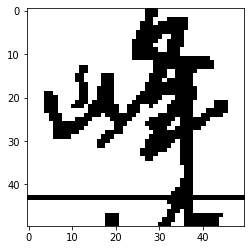


bound gray shape  (50, 50)
bound gray thres  (50, 50)
bound adter convert  (50, 50, 3)
torch.Size([3, 50, 50])
torch.Size([1, 3, 50, 50])
tensor([4], device='cuda:0') tensor([0.9937], device='cuda:0')
Finish prediction
場


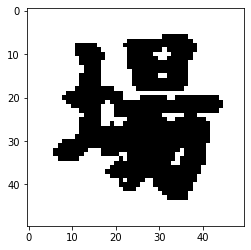

KeyboardInterrupt: Interrupted by user

In [42]:
for img_path in glob(os.path.join(path, 'Origin', '*.jpg')):
    img = cv2.imread(img_path, 0)
    pred_label, tmp_bound = predict_img(img)
    print(pred_label)
    plt.imshow(tmp_bound)
    plt.show()
    input()